### Using counts from https://data.nemoarchive.org/biccn/grant/u19_zeng/zeng/transcriptome/scell/10x_v3/mouse/processed/MOp/CellRanger5/*.mex.tar.gz

downloaded to /scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_gene_counts

In [36]:
stem = '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_gene_counts'

samples = [
    'L8TX_181211_01_A01',
    'L8TX_181211_01_B01',
    'L8TX_190430_01_A08',
    'L8TX_190430_01_B08',
    'L8TX_190430_01_C08',
    'L8TX_190430_01_D08',
    'L8TX_190430_01_E08',
    'L8TX_190430_01_F08',
    'L8TX_190430_01_G08',
    'L8TX_190430_01_H08',
]

genes_of_interest = [
    'Rbp1',
    'Cpsf6',
    'Celf1',
    'Nanos3', #miR-181c proxy
    'Gm14636', #miR-221 proxy
    'Timp3',
]

In [37]:
meta_df = pd.read_csv(
    '../../../readzs_fork/MOp_10Xv3_metadata_with_mouse.tsv',
    sep = '\t',
)
meta_df.head()

,cell_id,cluster_id,library,cell_bc,cluster_label,subclass_label,class_label,cluster_color,size,mouse
0,L8TX_181211_01_G12_AAACCCAAGCTTCATG,42,L8TX_181211_01_G12,AAACCCAAGCTTCATG,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
1,L8TX_181211_01_G12_AAACCCACACCAGCCA,42,L8TX_181211_01_G12,AAACCCACACCAGCCA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
2,L8TX_181211_01_G12_AAACGAACAACGATTC,42,L8TX_181211_01_G12,AAACGAACAACGATTC,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
3,L8TX_181211_01_G12_AAACGAATCTCGTGAA,42,L8TX_181211_01_G12,AAACGAATCTCGTGAA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
4,L8TX_181211_01_G12_AAACGCTGTAGTCACT,42,L8TX_181211_01_G12,AAACGCTGTAGTCACT,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003


In [38]:
#Get counts
df = pd.DataFrame()

for sample in samples:
    
    if sample not in meta_df['library'].values:
        continue
    
    print(sample)
    
    #Read in the counts table
    mtx = pd.read_csv(
        os.path.join(stem,sample,'matrix.mtx'),
        comment = '%',
        sep = ' ',
    )
    mtx.columns = ['feature','barcode','count']


    #Read in the barcodes
    bcs = pd.read_csv(
        os.path.join(stem,sample,'barcodes.tsv'),
        header = None,
        names = ['sequence'],
        sep='\t',
    )
    bcs.index.name = 'barcode'
    bcs = bcs.reset_index()
    bcs['sequence'] = bcs['sequence'].str.replace('-1','')
    bcs['barcode'] += 1
    seq_to_bc = dict(bcs[['sequence','barcode']].values)
    meta_subset = meta_df[meta_df['library'].eq(sample)].copy()
    meta_subset['barcode'] = meta_subset['cell_bc'].map(seq_to_bc)
    bc_to_ont = dict(meta_subset.dropna()[['barcode','subclass_label']].values)

    #Read in the genes
    genes = pd.read_csv(
        os.path.join(stem,sample,'features.tsv'),
        header = None,
        names = ['ENSMUSG','name','kind'],
        sep='\t',
    )
    genes.index.name = 'feature'
    genes = genes.reset_index()
    genes['feature'] += 1
    
    #calculate the number of reads for each ontology over all genes
    mtx['ont'] = mtx['barcode'].map(bc_to_ont)
    tot_counts = mtx.groupby('ont')['count'].sum()
    
    #get the associated feature number of the genes of interest
    gene_to_feature = dict(genes[genes['name'].isin(genes_of_interest)][['name','feature']].values)
    feature_to_gene = {v: k for k, v in gene_to_feature.items()}
    
    subset = mtx[mtx['feature'].isin(gene_to_feature.values())]
    subset = subset.merge(bcs)
    subset['gene'] = subset['feature'].map(feature_to_gene)
    
    wide_df = (
        subset.groupby(['ont','gene']).agg(
            count = ('count','sum'),
            num_cells = ('barcode','nunique'),
        )
        .reset_index()
        .pivot(
            index='ont',
            columns='gene',
            values='count',
        )
        .fillna(0)
    )

    wide_df['total_reads'] = tot_counts
    wide_df['num_cells'] = subset.groupby('ont')['barcode'].nunique()
    wide_df['sample'] = sample
    wide_df = wide_df.reset_index()
    
    df = pd.concat((df,wide_df))
    
df

L8TX_181211_01_A01
L8TX_181211_01_B01
L8TX_190430_01_A08
L8TX_190430_01_B08
L8TX_190430_01_F08
L8TX_190430_01_G08


gene,ont,Celf1,Cpsf6,Gm14636,Nanos3,Rbp1,Timp3,total_reads,num_cells,sample
0,L2/3 IT,16145.0,3729.0,1081.0,200.0,9.0,198.0,37697097,796,L8TX_181211_01_A01
1,L5 ET,153.0,75.0,14.0,4.0,1.0,0.0,658298,18,L8TX_181211_01_A01
2,L5 IT,31949.0,8456.0,2751.0,406.0,16.0,203.0,82973098,2180,L8TX_181211_01_A01
3,L5/6 NP,1319.0,566.0,67.0,46.0,12.0,18.0,5643110,186,L8TX_181211_01_A01
4,L6 CT,6976.0,2246.0,605.0,90.0,24.0,49.0,23457992,572,L8TX_181211_01_A01
...,...,...,...,...,...,...,...,...,...,...
14,Pvalb,562.0,362.0,2.0,24.0,0.0,18.0,3620041,78,L8TX_190430_01_G08
15,Sncg,564.0,290.0,2.0,14.0,1.0,33.0,3129725,56,L8TX_190430_01_G08
16,Sst,2054.0,980.0,6.0,56.0,84.0,1098.0,10859076,208,L8TX_190430_01_G08
17,VLMC,0.0,0.0,0.0,0.0,0.0,1.0,2993,1,L8TX_190430_01_G08


In [5]:
df.head()

gene,ont,Celf1,Cpsf6,Gm14636,Nanos3,Rbp1,total_reads,num_cells,sample
0,L2/3 IT,16145.0,3729.0,1081.0,200.0,9.0,37697097,796,L8TX_181211_01_A01
1,L5 ET,153.0,75.0,14.0,4.0,1.0,658298,18,L8TX_181211_01_A01
2,L5 IT,31949.0,8456.0,2751.0,406.0,16.0,82973098,2180,L8TX_181211_01_A01
3,L5/6 NP,1319.0,566.0,67.0,46.0,12.0,5643110,186,L8TX_181211_01_A01
4,L6 CT,6976.0,2246.0,605.0,90.0,24.0,23457992,572,L8TX_181211_01_A01


In [39]:
df.to_csv('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_gene_counts/counts.csv',index=False)

In [7]:
df = pd.read_csv('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_gene_counts/counts.csv')
agg_df = df.groupby(['ont']).sum()
agg_df['avg_reads_per_cell'] = agg_df['total_reads'].div(agg_df['num_cells'])
agg_df.head()

,Celf1,Cpsf6,Gm14636,Nanos3,Rbp1,Timp3,total_reads,num_cells,avg_reads_per_cell
ont,,,,,,,,,
Astro,264.0,155.0,6.0,4.0,53.0,496.0,1473557,186,7922.349462
Endo,148.0,76.0,2.0,1.0,9.0,640.0,735973,87,8459.459770
L2/3 IT,125265.0,25838.0,7182.0,1755.0,35.0,2225.0,304444280,5695,53458.170325
L5 ET,848.0,393.0,58.0,18.0,2.0,8.0,3267377,81,40337.987654
L5 IT,247376.0,60470.0,14737.0,3484.0,126.0,1769.0,691732708,15354,45052.280057


In [8]:
genes = ['Timp3','Nanos3','Gm14636','Rbp1','Celf1','Cpsf6']
for gene in genes:
    agg_df[gene] = agg_df[gene].div(agg_df['avg_reads_per_cell'])
    
agg_df

,Celf1,Cpsf6,Gm14636,Nanos3,Rbp1,Timp3,total_reads,num_cells,avg_reads_per_cell
ont,,,,,,,,,
Astro,0.033323,0.019565,0.000757,0.000505,0.006690,0.062608,1473557,186,7922.349462
Endo,0.017495,0.008984,0.000236,0.000118,0.001064,0.075655,735973,87,8459.459770
L2/3 IT,2.343234,0.483331,0.134348,0.032829,0.000655,0.041621,304444280,5695,53458.170325
L5 ET,0.021022,0.009743,0.001438,0.000446,0.000050,0.000198,3267377,81,40337.987654
L5 IT,5.490865,1.342218,0.327109,0.077332,0.002797,0.039265,691732708,15354,45052.280057
L5/6 NP,0.382972,0.160613,0.015235,0.010022,0.002995,0.005846,58577995,1687,34723.174274
L6 CT,2.247283,0.648673,0.170087,0.028067,0.005293,0.021984,362451561,7736,46852.580274
L6 IT,0.818108,0.201820,0.103220,0.008876,0.001242,0.028983,137056285,2503,54756.805833
L6 IT Car3,0.013023,0.004113,0.001195,0.000039,0.000000,0.000078,2297832,45,51062.933333


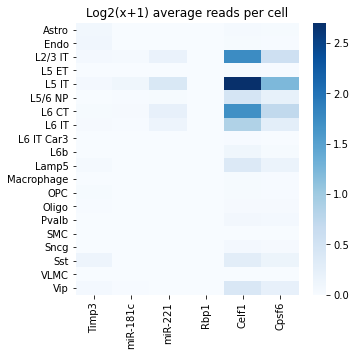

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

data = np.log2(agg_df[genes]+1)
data = data.rename(columns={'Nanos3':'miR-181c','Gm14636':'miR-221'})

fig = plt.figure(figsize=(5,5))
sns.heatmap(
    data,
    cmap = 'Blues',
)
plt.xlabel('')
plt.ylabel('')
plt.title('Log2(x+1) average reads per cell')
plt.show()
#plt.savefig('timp3_miRNA_RBP_expression.svg')
plt.close()

In [6]:
data

,Timp3,miR-181c,miR-221,Rbp1,Celf1,Cpsf6
ont,,,,,,
Astro,0.026373,0.000219,0.000329,0.002896,0.014236,0.008415
Endo,0.031673,0.000051,0.000103,0.000462,0.007532,0.003884
L2/3 IT,0.017710,0.014029,0.054746,0.000284,0.524167,0.171238
L5 ET,0.000086,0.000194,0.000624,0.000022,0.009035,0.004211
L5 IT,0.016727,0.032350,0.122907,0.001213,0.812303,0.369627
L5/6 NP,0.002532,0.004331,0.006566,0.001299,0.140813,0.064688
L6 CT,0.009444,0.012021,0.068218,0.002293,0.511520,0.217135
L6 IT,0.012408,0.003838,0.042662,0.000539,0.259620,0.079839
L6 IT Car3,0.000034,0.000017,0.000519,0.000000,0.005619,0.001782


In [9]:
agg_df[genes]

,Timp3,Nanos3,Gm14636,Rbp1,Celf1,Cpsf6
ont,,,,,,
Astro,0.062608,0.000505,0.000757,0.006690,0.033323,0.019565
Endo,0.075655,0.000118,0.000236,0.001064,0.017495,0.008984
L2/3 IT,0.041621,0.032829,0.134348,0.000655,2.343234,0.483331
L5 ET,0.000198,0.000446,0.001438,0.000050,0.021022,0.009743
L5 IT,0.039265,0.077332,0.327109,0.002797,5.490865,1.342218
L5/6 NP,0.005846,0.010022,0.015235,0.002995,0.382972,0.160613
L6 CT,0.021984,0.028067,0.170087,0.005293,2.247283,0.648673
L6 IT,0.028983,0.008876,0.103220,0.001242,0.818108,0.201820
L6 IT Car3,0.000078,0.000039,0.001195,0.000000,0.013023,0.004113


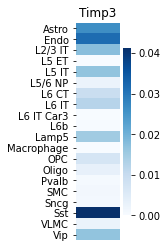

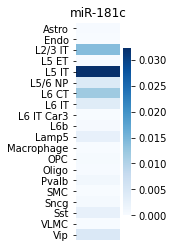

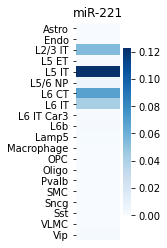

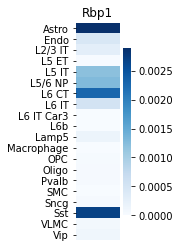

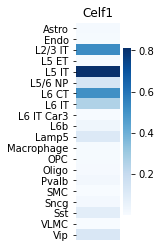

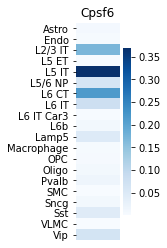

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

data = np.log10(agg_df[genes]+1)
data = data.rename(columns={'Nanos3':'miR-181c','Gm14636':'miR-221'})

for gene in data.columns:
    fig = plt.figure(figsize=(1,4))
    sns.heatmap(
        data[[gene]],
        cmap = 'Blues',
    )
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.title('{}'.format(gene))
    plt.show()
    #plt.savefig('timp3_miRNA_RBP_expression_{}.svg'.format(gene))
    plt.close()

In [59]:
agg_df

gene,Celf1,Cpsf6,Gm14636,Nanos3,Rbp1,Timp3,total_reads,num_cells
ont,,,,,,,,
Astro,1.419355,0.833333,0.032258,0.021505,0.284946,2.666667,1473557,186
Endo,1.701149,0.873563,0.022989,0.011494,0.103448,7.356322,735973,87
L2/3 IT,21.995610,4.536962,1.261106,0.308165,0.006146,0.390694,304444280,5695
L5 ET,10.469136,4.851852,0.716049,0.222222,0.024691,0.098765,3267377,81
L5 IT,16.111502,3.938387,0.959815,0.226912,0.008206,0.115214,691732708,15354
L5/6 NP,7.882632,3.305868,0.313574,0.206283,0.061648,0.120332,58577995,1687
L6 CT,13.610522,3.928645,1.030119,0.169984,0.032058,0.133144,362451561,7736
L6 IT,17.897323,4.415102,2.258090,0.194167,0.027167,0.634039,137056285,2503
L6 IT Car3,14.777778,4.666667,1.355556,0.044444,0.000000,0.088889,2297832,45


In [50]:
df.groupby('ont')[['Timp3','num_cells']].sum()

gene,Timp3,num_cells
ont,,
Astro,496.0,186
Endo,640.0,87
L2/3 IT,2225.0,5695
L5 ET,8.0,81
L5 IT,1769.0,15354
L5/6 NP,203.0,1687
L6 CT,1030.0,7736
L6 IT,1587.0,2503
L6 IT Car3,4.0,45


In [94]:
agg_df['Timp3'].sort_values()

ont
Macrophage    0.000000
L6 IT Car3    0.000078
L5 ET         0.000198
L6b           0.000598
Pvalb         0.001704
Sncg          0.001927
SMC           0.002655
VLMC          0.005599
L5/6 NP       0.005846
Oligo         0.008113
OPC           0.016721
L6 CT         0.021984
L6 IT         0.028983
Lamp5         0.035513
Vip           0.039020
L5 IT         0.039265
L2/3 IT       0.041621
Astro         0.062608
Endo          0.075655
Sst           0.099727
Name: Timp3, dtype: float64

In [92]:
agg_df['Nanos3'].sort_values()

ont
SMC           0.000000
Macrophage    0.000000
VLMC          0.000000
L6 IT Car3    0.000039
Endo          0.000118
Oligo         0.000357
L5 ET         0.000446
Astro         0.000505
OPC           0.000611
L6b           0.001157
Sncg          0.001232
Pvalb         0.002526
Lamp5         0.006154
Sst           0.006344
L6 IT         0.008876
L5/6 NP       0.010022
Vip           0.010981
L6 CT         0.028067
L2/3 IT       0.032829
L5 IT         0.077332
Name: Nanos3, dtype: float64

In [93]:
normalized_df['Gm14636'].sort_values()

ont
SMC           0.000000
VLMC          0.000000
Oligo         0.006395
Pvalb         0.009787
Endo          0.010181
Sst           0.010334
Macrophage    0.011809
Astro         0.014286
Sncg          0.025620
OPC           0.035632
Lamp5         0.039304
Vip           0.039710
L5/6 NP       0.138867
L5 ET         0.317104
L6b           0.335899
L5 IT         0.425056
L6 CT         0.456190
L2/3 IT       0.558484
L6 IT Car3    0.600311
L6 IT         1.000000
Name: Gm14636, dtype: float64

In [97]:
normalized_df['Rbp1'].sort_values()

ont
L6b           0.000000
SMC           0.000000
Macrophage    0.000000
L6 IT Car3    0.000000
Vip           0.015962
L2/3 IT       0.021568
Oligo         0.025339
L5 IT         0.028800
Pvalb         0.038778
OPC           0.040338
Lamp5         0.043174
Sncg          0.058007
L5 ET         0.086653
L6 IT         0.095342
L6 CT         0.112505
VLMC          0.167116
L5/6 NP       0.216349
Endo          0.363045
Sst           0.903899
Astro         1.000000
Name: Rbp1, dtype: float64

In [6]:
df['sample'].nunique()

6

In [15]:
bc_to_ont

{2.0: 'L5 IT',
 3.0: 'L5 IT',
 10.0: 'L5 IT',
 12.0: 'L5 IT',
 19.0: 'L5 IT',
 20.0: 'L5 IT',
 27.0: 'L5 IT',
 30.0: 'L5 IT',
 31.0: 'L5 IT',
 40.0: 'L5 IT',
 48.0: 'L5 IT',
 64.0: 'L5 IT',
 65.0: 'L5 IT',
 66.0: 'L5 IT',
 71.0: 'L5 IT',
 76.0: 'L5 IT',
 80.0: 'L5 IT',
 87.0: 'L5 IT',
 103.0: 'L5 IT',
 104.0: 'L5 IT',
 115.0: 'L5 IT',
 141.0: 'L5 IT',
 148.0: 'L5 IT',
 157.0: 'L5 IT',
 160.0: 'L5 IT',
 181.0: 'L5 IT',
 189.0: 'L5 IT',
 200.0: 'L5 IT',
 207.0: 'L5 IT',
 224.0: 'L5 IT',
 242.0: 'L5 IT',
 243.0: 'L5 IT',
 264.0: 'L5 IT',
 275.0: 'L5 IT',
 282.0: 'L5 IT',
 315.0: 'L5 IT',
 319.0: 'L5 IT',
 321.0: 'L5 IT',
 329.0: 'L5 IT',
 338.0: 'L5 IT',
 343.0: 'L5 IT',
 345.0: 'L5 IT',
 347.0: 'L5 IT',
 357.0: 'L5 IT',
 360.0: 'L5 IT',
 364.0: 'L5 IT',
 367.0: 'L5 IT',
 376.0: 'L5 IT',
 380.0: 'L5 IT',
 384.0: 'L5 IT',
 387.0: 'L5 IT',
 421.0: 'L5 IT',
 425.0: 'L5 IT',
 428.0: 'L5 IT',
 434.0: 'L5 IT',
 436.0: 'L5 IT',
 443.0: 'L5 IT',
 447.0: 'L5 IT',
 449.0: 'L5 IT',
 453.0: 'L5 IT',


In [14]:
mtx['barcode']

0               1
1               1
2               1
3               1
4               1
            ...  
66628912    11941
66628913    11941
66628914    11941
66628915    11941
66628916    11941
Name: barcode, Length: 66628917, dtype: int64

In [13]:
mtx['barcode'].map(bc_to_ont)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [12]:
bc_to_ont

{2.0: 'L5 IT',
 3.0: 'L5 IT',
 10.0: 'L5 IT',
 12.0: 'L5 IT',
 19.0: 'L5 IT',
 20.0: 'L5 IT',
 27.0: 'L5 IT',
 30.0: 'L5 IT',
 31.0: 'L5 IT',
 40.0: 'L5 IT',
 48.0: 'L5 IT',
 64.0: 'L5 IT',
 65.0: 'L5 IT',
 66.0: 'L5 IT',
 71.0: 'L5 IT',
 76.0: 'L5 IT',
 80.0: 'L5 IT',
 87.0: 'L5 IT',
 103.0: 'L5 IT',
 104.0: 'L5 IT',
 115.0: 'L5 IT',
 141.0: 'L5 IT',
 148.0: 'L5 IT',
 157.0: 'L5 IT',
 160.0: 'L5 IT',
 181.0: 'L5 IT',
 189.0: 'L5 IT',
 200.0: 'L5 IT',
 207.0: 'L5 IT',
 224.0: 'L5 IT',
 242.0: 'L5 IT',
 243.0: 'L5 IT',
 264.0: 'L5 IT',
 275.0: 'L5 IT',
 282.0: 'L5 IT',
 315.0: 'L5 IT',
 319.0: 'L5 IT',
 321.0: 'L5 IT',
 329.0: 'L5 IT',
 338.0: 'L5 IT',
 343.0: 'L5 IT',
 345.0: 'L5 IT',
 347.0: 'L5 IT',
 357.0: 'L5 IT',
 360.0: 'L5 IT',
 364.0: 'L5 IT',
 367.0: 'L5 IT',
 376.0: 'L5 IT',
 380.0: 'L5 IT',
 384.0: 'L5 IT',
 387.0: 'L5 IT',
 421.0: 'L5 IT',
 425.0: 'L5 IT',
 428.0: 'L5 IT',
 434.0: 'L5 IT',
 436.0: 'L5 IT',
 443.0: 'L5 IT',
 447.0: 'L5 IT',
 449.0: 'L5 IT',
 453.0: 'L5 IT',


ont
L2/3 IT        796
L5 ET           18
L5 IT         2180
L5/6 NP        186
L6 CT          572
L6 IT          202
L6 IT Car3       1
L6b              8
Lamp5          225
Macrophage       1
Oligo            9
Sncg            13
Sst             75
Vip            232
Name: barcode, dtype: int64

In [6]:
wide_df = (
    subset.groupby(['ont','gene']).agg(
        count = ('count','sum'),
        num_cells = ('barcode','nunique'),
    )
    .reset_index()
    .pivot(
        index='ont',
        columns='gene',
        values='count',
    )
    .fillna(0)
)

NameError: name 'subset' is not defined

In [124]:
tot_counts

ont
L2/3 IT        6314762
L5 ET           121137
L5 IT         15641516
L5/6 NP        1235459
L6 CT          4222473
L6 IT          1589610
L6 IT Car3        7253
L6b              65327
Lamp5          1638843
Macrophage        2298
Oligo            40161
Sncg             91700
Sst             569920
Vip            1388821
dtype: int64

In [127]:

wide_df

gene,ont,Celf1,Cpsf6,Gm14636,Nanos3,Rbp1,total_reads,sample
0,L2/3 IT,16145.0,3729.0,1081.0,200.0,9.0,37697097,L8TX_181211_01_A01
1,L5 ET,153.0,75.0,14.0,4.0,1.0,658298,L8TX_181211_01_A01
2,L5 IT,31949.0,8456.0,2751.0,406.0,16.0,82973098,L8TX_181211_01_A01
3,L5/6 NP,1319.0,566.0,67.0,46.0,12.0,5643110,L8TX_181211_01_A01
4,L6 CT,6976.0,2246.0,605.0,90.0,24.0,23457992,L8TX_181211_01_A01
5,L6 IT,3260.0,916.0,498.0,36.0,5.0,9505498,L8TX_181211_01_A01
6,L6 IT Car3,9.0,3.0,0.0,0.0,0.0,33282,L8TX_181211_01_A01
7,L6b,121.0,40.0,8.0,0.0,0.0,456857,L8TX_181211_01_A01
8,Lamp5,2233.0,900.0,16.0,45.0,5.0,8249397,L8TX_181211_01_A01
9,Macrophage,5.0,0.0,0.0,0.0,0.0,4605,L8TX_181211_01_A01


In [117]:
subset.pivot(
    index='ont',
    columns='gene',
    values='count',
)

ValueError: Index contains duplicate entries, cannot reshape

In [111]:
gene_to_feature = dict(genes[genes['name'].isin(genes_of_interest)][['name','feature']].values)
feature_to_gene = {v: k for k, v in gene_to_feature.items()}
subset = mtx[mtx['feature'].isin(gene_to_feature.values())]
subset = subset.merge(bcs)
subset['gene'] = subset['feature'].map(feature_to_gene)
subset['sample'] = sample

In [112]:
subset.pivot()

,feature,barcode,count,ont,sequence,gene,sample
0,2936,1,12,NaN,AAACCCAAGGTGTGAC,Celf1,L8TX_181211_01_A01
1,18370,1,2,NaN,AAACCCAAGGTGTGAC,Cpsf6,L8TX_181211_01_A01
2,30505,1,5,NaN,AAACCCAAGGTGTGAC,Gm14636,L8TX_181211_01_A01
3,2936,2,8,L6 IT,AAACCCAAGTTGGACG,Celf1,L8TX_181211_01_A01
4,30505,2,2,L6 IT,AAACCCAAGTTGGACG,Gm14636,L8TX_181211_01_A01
...,...,...,...,...,...,...,...
19189,2936,9675,28,L5 IT,TTTGTTGTCTCGCTCA,Celf1,L8TX_181211_01_A01
19190,18370,9675,5,L5 IT,TTTGTTGTCTCGCTCA,Cpsf6,L8TX_181211_01_A01
19191,30505,9675,1,L5 IT,TTTGTTGTCTCGCTCA,Gm14636,L8TX_181211_01_A01
19192,2936,9676,22,L5 IT,TTTGTTGTCTGCACCT,Celf1,L8TX_181211_01_A01


In [108]:

tot_reads

,ont,tot_reads
0,L2/3 IT,6314762
1,L5 ET,121137
2,L5 IT,15641516
3,L5/6 NP,1235459
4,L6 CT,4222473
5,L6 IT,1589610
6,L6 IT Car3,7253
7,L6b,65327
8,Lamp5,1638843
9,Macrophage,2298


In [104]:
mtx.head()

,feature,barcode,count,ont
0,1,1,32,NaN
1,3,1,1,NaN
2,10,1,4,NaN
3,11,1,3,NaN
4,12,1,3,NaN


In [71]:
df.head()

,feature,barcode,count,sequence,gene,sample
0,2936,1,12,AAACCCAAGGTGTGAC-1,Celf1,L8TX_181211_01_A01
1,18370,1,2,AAACCCAAGGTGTGAC-1,Cpsf6,L8TX_181211_01_A01
2,30505,1,5,AAACCCAAGGTGTGAC-1,Gm14636,L8TX_181211_01_A01
3,2936,2,8,AAACCCAAGTTGGACG-1,Celf1,L8TX_181211_01_A01
4,30505,2,2,AAACCCAAGTTGGACG-1,Gm14636,L8TX_181211_01_A01


In [16]:
mtx.head()

,feature,barcode,count
0,1,1,32
1,3,1,1
2,10,1,4
3,11,1,3
4,12,1,3


In [31]:
mtx['feature'].max()

32285

In [18]:
mtx['barcode'].max()

9676

# Counting from alignments

In [4]:
bam_paths = glob.glob('/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX*.bam')
bam_paths

['/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_A01.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_F01.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_190430_01_G08.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_C01.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_190430_01_A08.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_E01.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_G12.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_190430_01_F08.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_H12.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_181211_01_B01.bam',
 '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/10X_mapping/L8TX_190430_01_B08.bam']

In [5]:
meta_df = pd.read_csv('../../../readzs_fork/MOp_10Xv3_metadata_with_mouse.tsv',sep='\t')
meta_df.head()

,cell_id,cluster_id,library,cell_bc,cluster_label,subclass_label,class_label,cluster_color,size,mouse
0,L8TX_181211_01_G12_AAACCCAAGCTTCATG,42,L8TX_181211_01_G12,AAACCCAAGCTTCATG,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
1,L8TX_181211_01_G12_AAACCCACACCAGCCA,42,L8TX_181211_01_G12,AAACCCACACCAGCCA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
2,L8TX_181211_01_G12_AAACGAACAACGATTC,42,L8TX_181211_01_G12,AAACGAACAACGATTC,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
3,L8TX_181211_01_G12_AAACGAATCTCGTGAA,42,L8TX_181211_01_G12,AAACGAATCTCGTGAA,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003
4,L8TX_181211_01_G12_AAACGCTGTAGTCACT,42,L8TX_181211_01_G12,AAACGCTGTAGTCACT,L5 IT Tcap_2,L5 IT,Glutamatergic,#52CA74,17334,426003


In [29]:
regions = {
    'miR-181c':('chr8',84178873,84178961),
    'miR-221':('chrX',19146294,19146388),
    'Crbp':('chr9',98422961,98446575),
    'Cpsf6':('chr10',117344673,117376970),
    'Celf1':('chr2',90940397,91019490),
}

In [31]:
seen_bcs = {
    'gene':[],
    'library':[],
    'cell_bc':[],
}

for bam_path in bam_paths:
    library = os.path.basename(bam_path).replace('.bam','')
    with pysam.AlignmentFile(bam_path) as bam_f:
        for gene,region in regions.items():
            num_reads = 0
            for r in bam_f.fetch(*region):
                try:
                    cb = r.get_tag('CB')
                    seen_bcs['gene'].append(gene)
                    seen_bcs['library'].append(library)
                    seen_bcs['cell_bc'].append(cb.replace('-1',''))
                except KeyError:
                    continue
            
hits = pd.DataFrame(seen_bcs)
hits = hits.merge(meta_df)
hits

,gene,library,cell_bc,cell_id,cluster_id,cluster_label,subclass_label,class_label,cluster_color,size,mouse
0,miR-181c,L8TX_181211_01_A01,GTTACAGCATCTATCT,L8TX_181211_01_A01_GTTACAGCATCTATCT,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275,426003
1,Cpsf6,L8TX_181211_01_A01,GTTACAGCATCTATCT,L8TX_181211_01_A01_GTTACAGCATCTATCT,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275,426003
2,Cpsf6,L8TX_181211_01_A01,GTTACAGCATCTATCT,L8TX_181211_01_A01_GTTACAGCATCTATCT,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275,426003
3,Cpsf6,L8TX_181211_01_A01,GTTACAGCATCTATCT,L8TX_181211_01_A01_GTTACAGCATCTATCT,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275,426003
4,Celf1,L8TX_181211_01_A01,GTTACAGCATCTATCT,L8TX_181211_01_A01_GTTACAGCATCTATCT,5,Lamp5 Slc35d3_1,Lamp5,GABAergic,#FFA388,1275,426003
...,...,...,...,...,...,...,...,...,...,...,...
5307563,Celf1,L8TX_190430_01_B08,AACTTCTAGAGTGACC,L8TX_190430_01_B08_AACTTCTAGAGTGACC,16,Vip Chat,Vip,GABAergic,#FF00FF,498,457911
5307564,Celf1,L8TX_190430_01_B08,AACTTCTAGAGTGACC,L8TX_190430_01_B08_AACTTCTAGAGTGACC,16,Vip Chat,Vip,GABAergic,#FF00FF,498,457911
5307565,Celf1,L8TX_190430_01_B08,AACTTCTAGAGTGACC,L8TX_190430_01_B08_AACTTCTAGAGTGACC,16,Vip Chat,Vip,GABAergic,#FF00FF,498,457911
5307566,Celf1,L8TX_190430_01_B08,CTGCCTAGTCACCACG,L8TX_190430_01_B08_CTGCCTAGTCACCACG,70,OPC Pdgfra,OPC,Non-Neuronal,#476655,146,457911


In [41]:
hits_agg = hits.groupby(
    ['gene','mouse','subclass_label']
).size().reset_index(name='count').sort_values('count',ascending=False)

hits_agg = hits_agg.groupby(['gene','subclass_label']).agg(
    avg_count_per_mouse = ('count','mean'),
    std_count_per_mouse = ('count','std'),
).reset_index().sort_values('avg_count_per_mouse',ascending=False)

hits_agg.head(50)

,gene,subclass_label,avg_count_per_mouse,std_count_per_mouse
4,Celf1,L5 IT,475558.25,187131.279494
2,Celf1,L2/3 IT,235348.00,90451.892687
6,Celf1,L6 CT,170698.75,47462.220073
24,Cpsf6,L5 IT,105613.00,48755.271640
7,Celf1,L6 IT,76904.00,25357.171306
22,Cpsf6,L2/3 IT,46421.00,22748.415549
26,Cpsf6,L6 CT,45167.75,14613.477601
10,Celf1,Lamp5,25969.75,16098.329880
5,Celf1,L5/6 NP,24876.00,11128.622047
19,Celf1,Vip,18883.25,9440.304069


In [39]:
hits_agg['gene'].unique()

array(['Celf1', 'Cpsf6', 'Crbp', 'miR-181c', 'miR-221'], dtype=object)

In [50]:
hits_agg[hits_agg['gene'].eq('miR-181c')].head(20).reset_index(drop=True)

,gene,subclass_label,avg_count_per_mouse,std_count_per_mouse
0,miR-181c,L5 IT,817.250000,200.063948
1,miR-181c,L2/3 IT,416.250000,115.127104
2,miR-181c,L6 CT,326.750000,63.363370
3,miR-181c,L6 IT,108.000000,26.993826
4,miR-181c,L5/6 NP,75.750000,19.568257
5,miR-181c,Lamp5,59.000000,22.315914
6,miR-181c,Sst,52.750000,8.539126
7,miR-181c,Vip,48.250000,16.317169
8,miR-181c,Pvalb,37.000000,15.556349
9,miR-181c,L6b,21.250000,20.418537


In [52]:
hits_agg[hits_agg['gene'].eq('miR-221')].head(20).reset_index(drop=True)

,gene,subclass_label,avg_count_per_mouse,std_count_per_mouse
0,miR-221,L5 IT,302.75,100.480098
1,miR-221,L2/3 IT,124.75,35.112913
2,miR-221,L6 CT,121.25,34.072227
3,miR-221,L6 IT,75.75,7.182154
4,miR-221,L5/6 NP,14.50,2.516611
5,miR-221,Vip,10.75,6.291529
6,miR-221,Oligo,10.00,NaN
7,miR-221,L6b,8.50,7.937254
8,miR-221,Lamp5,7.50,4.203173
9,miR-221,Sst,6.50,5.686241


In [53]:
hits_agg[hits_agg['gene'].eq('Crbp')].head(20).reset_index(drop=True)

,gene,subclass_label,avg_count_per_mouse,std_count_per_mouse
0,Crbp,L6 CT,393.75,57.465207
1,Crbp,Sst,328.75,86.619378
2,Crbp,L5 IT,220.00,93.127153
3,Crbp,L5/6 NP,196.50,77.976492
4,Crbp,Astro,145.25,110.276546
5,Crbp,L6 IT,86.75,31.742453
6,Crbp,L2/3 IT,63.25,41.843956
7,Crbp,Lamp5,40.50,26.639570
8,Crbp,Endo,24.75,23.556669
9,Crbp,Vip,12.50,6.244998


In [55]:
hits_agg['gene'].unique()

array(['Celf1', 'Cpsf6', 'miR-181c', 'Crbp', 'miR-221'], dtype=object)

In [56]:
hits_agg[hits_agg['gene'].eq('Celf1')].head(20).reset_index(drop=True)

,gene,subclass_label,avg_count_per_mouse,std_count_per_mouse
0,Celf1,L5 IT,475558.25,187131.279494
1,Celf1,L2/3 IT,235348.00,90451.892687
2,Celf1,L6 CT,170698.75,47462.220073
3,Celf1,L6 IT,76904.00,25357.171306
4,Celf1,Lamp5,25969.75,16098.329880
5,Celf1,L5/6 NP,24876.00,11128.622047
6,Celf1,Vip,18883.25,9440.304069
7,Celf1,Sst,17219.75,5193.969283
8,Celf1,L6b,8786.75,8899.311373
9,Celf1,Sncg,3127.00,675.328562


In [57]:
hits_agg[hits_agg['gene'].eq('Cpsf6')].head(20).reset_index(drop=True)

,gene,subclass_label,avg_count_per_mouse,std_count_per_mouse
0,Cpsf6,L5 IT,105613.000000,48755.271640
1,Cpsf6,L2/3 IT,46421.000000,22748.415549
2,Cpsf6,L6 CT,45167.750000,14613.477601
3,Cpsf6,L6 IT,17677.250000,7001.563986
4,Cpsf6,L5/6 NP,9573.750000,4833.699299
5,Cpsf6,Lamp5,9070.250000,5677.160345
6,Cpsf6,Vip,8474.250000,4448.685377
7,Cpsf6,Sst,7635.750000,2574.373241
8,Cpsf6,L6b,2143.250000,2306.441180
9,Cpsf6,Pvalb,1654.250000,1977.995176


In [45]:
ss2_path = '/scratch/groups/horence/rob/data/MERFISH_scRNAseq/ss2_bam_tagging/tagged_bams/LS-15501_S46_E1-50.bam'
with pysam.AlignmentFile(ss2_path) as bam_f:
    for r in bam_f:
        break

In [46]:
r.get_tags()

[('NH', 10),
 ('HI', 9),
 ('AS', 100),
 ('nM', 0),
 ('CB', 'LS-15501_S46_E1-50'),
 ('UB', 'CTCCATAGGAGA')]

In [59]:
seq = pd.read_csv('../outputs/gene_cell/SeqFish_peripheral.csv')
seq['annotation'].unique()

array(['Endothelial', 'OPC', 'Interneuron', 'Microglia',
       'Excitatory layer 4', 'Excitatory layer 3',
       'Astrocytes superficial', 'Excitatory layer II', 'Astrocytes deep',
       'Interneurons deep', 'Excitatory layer 5/6', 'Excitatory 5/6',
       'Neuroblasts', 'Neuroblast', 'Oligodendrocytes', 'NSC',
       'unannotated', 'Neural progenitors', 'choroid plexus', 'Ependymal'],
      dtype=object)

In [60]:
merf = pd.read_csv('../outputs/gene_cell/Merfish_MOp_peripheral.csv')
merf['annotation'].unique()

array(['Astro_1', 'unannotated', 'L23_IT_4', 'SMC', 'L45_IT_2', 'Pvalb_6',
       'L6_CT_1', 'L45_IT_1', 'L23_IT_3', 'Oligo_3', 'Oligo_2', 'L6_IT_1',
       'L45_IT_SSp_2', 'L45_IT_5', 'L23_IT_2', 'Endo', 'L6_IT_3', 'Peri',
       'L45_IT_3', 'L45_IT_4', 'L5_IT_3', 'L6_CT_3', 'Lamp5_1', 'L6_CT_2',
       'striatum_1', 'L5_IT_4', 'Pvalb_3', 'Oligo_1', 'L5_IT_1',
       'L6_CT_6', 'Astro_2', 'L56_NP_2', 'Astro_3', 'L5_IT_2', 'Sst_5',
       'VLMC', 'L23_IT_1', 'L5_ET_3', 'L5_ET_5', 'PVM', 'L23_IT_5',
       'L6_CT_4', 'L6_IT_Car3', 'Sst_2', 'L56_NP_1', 'L45_IT_SSp_1',
       'OPC', 'Pvalb_5', 'Lamp5_5', 'L6_CT_5', 'L6b_2', 'Pvalb_1',
       'Lamp5_4', 'Pvalb_2', 'L5_ET_2', 'Sst_4', 'L6b_1', 'Pvalb_7',
       'Vip_5', 'Vip_10', 'Pvalb_10', 'L6_IT_2', 'Sst_1', 'Micro_1',
       'Sncg_1', 'Pvalb_9', 'Pvalb_8', 'ventricle_1', 'striatum_2',
       'Vip_1', 'L5_ET_1', 'Lamp5_6', 'Lamp5_3', 'Sst_6', 'Vip_7',
       'L6_CT_8', 'L6_CT_7', 'Sst_3', 'Pvalb_11', 'Vip_2', 'Vip_3',
       'Lamp5_7', '